# Traffic signs detection project #
Section 1: extracting features and using them on 3 models.

In [6]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

path_base = os.getcwd() + "\\databases"
train, test = np.load(os.path.join(path_base,'train.npy')), np.load(os.path.join(path_base,'test.npy'))

data changes:

In [7]:
# Change array of pictures of size 45x45 to array of pictures 45*45=2025:
x1 = train
x1 = x1.astype("float32") / 255
rows, cols = (4170, 2025)
train = np.array([[0]*cols]*rows)
train = train.astype("float32")
jump = 0
for i in range(0,rows):
    for j in range(0, 45):
        for k in range(0, 45):
            train[i][jump] = x1[i][j][k]
            jump = jump + 1
    jump = 0


x2 = test
x2 = x2.astype("float32") / 255
rows, cols = (1998, 2025)
test = np.array([[0]*cols]*rows)
test = test.astype("float32")
jump = 0
for i in range(0,rows):
    for j in range(0, 45):
        for k in range(0, 45):
            test[i][jump] = x2[i][j][k]
            jump = jump + 1
    jump = 0

get classification from file

In [8]:
path_pict = os.getcwd() + "\\pictures"

f = open(path_pict + "\\TsignRecgTrain4170Annotation.txt", "r")
str = f.read()

lines = str.split("\n")
arr = []
for line in lines:
    arr.append(int(line.split(";")[7]))
    
Train_classes = []
for i in range(58):
    for k in range(arr.count(i)):
        Train_classes.append(i)

#get classification from file
path_pict = os.getcwd() + "\\pictures"

f = open(path_pict + "\\TsignRecgTest1994Annotation.txt", "r")
str = f.read()

lines = str.split("\n")
arr = []
for line in lines:
    arr.append(int(line.split(";")[7]))
    
Test_classes = []
for i in range(58):
    for k in range(arr.count(i)):
        Test_classes.append(i)


check the best amount of components for pca and lda

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

Model_trainErr_PCA = []
Model_testErr_PCA = []
Model_trainErr_LDA = []
Model_testErr_LDA = []

for i in range(1,21,2):
    pca = PCA(n_components=i)
    t_pca_train = pca.fit_transform(train)
    t_pca_test = pca.transform(test)
    
    clf1 = RandomForestClassifier(max_depth=10, random_state=0)
    clf1.fit(t_pca_train, Train_classes)
    Model_trainErr_PCA.append(1-clf1.score(t_pca_train, Train_classes))
    Model_testErr_PCA.append(1-clf1.score(t_pca_test, Test_classes))
    
    lda = LinearDiscriminantAnalysis(n_components=i)
    t_lda_train = lda.fit_transform(train,Train_classes)
    t_lda_test = lda.transform(test)
    
    clf2 = RandomForestClassifier(max_depth=10, random_state=0)
    clf2.fit(t_lda_train, Train_classes)
    Model_trainErr_LDA.append(1-clf2.score(t_lda_train, Train_classes))
    Model_testErr_LDA.append(1-clf2.score(t_lda_test, Test_classes))


plot it

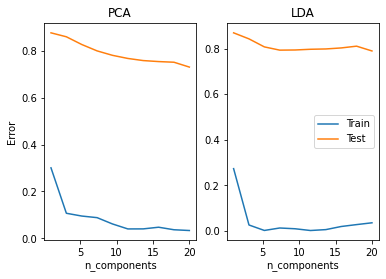

In [10]:
x = np.linspace(1, 20, 10) 
y1 = np.polyfit(x, Model_trainErr_PCA, 6)
p1 = np.poly1d(y1)
y2 = np.polyfit(x, Model_testErr_PCA, 6)
p2 = np.poly1d(y2)

y3 = np.polyfit(x, Model_trainErr_LDA, 6) 
p3 = np.poly1d(y3)
y4 = np.polyfit(x, Model_testErr_LDA, 6)
p4 = np.poly1d(y4)

plt.subplot(1, 2, 1)
plt.plot(x, p1(x), label="Train")
plt.plot(x, p2(x), label="Test")
plt.title("PCA")
plt.xlabel("n_components")
plt.ylabel("Error")

plt.subplot(1, 2, 2) # index 2
plt.plot(x, p3(x), label="Train")
plt.plot(x, p4(x), label="Test")
plt.title("LDA")
plt.xlabel("n_components")


plt.legend(loc="best") 
plt.show()

Use PCA and LDA with best amount of components:

In [11]:
pca = PCA(n_components=10)
pca_train = pca.fit_transform(train)
pca_test = pca.transform(test)

lda = LinearDiscriminantAnalysis(n_components=7)
lda_train = lda.fit_transform(train,Train_classes)
lda_test = lda.transform(test)

Print RF learning curves (PCA V.S LDA):

In [12]:
testErr_PCA = []
trainErr_PCA = []

testErr_LDA = []
trainErr_LDA = []

for i in range(170, 4170, 100):
    X_train = np.split(pca_train,[i,i])[0]
    y_train = np.split(Train_classes,[i,i])[0]
    clf1 = RandomForestClassifier(max_depth=10, random_state=0)
    clf1.fit(X_train, y_train)
    trainErr_PCA.append(1-clf1.score(X_train, y_train))
    testErr_PCA.append(1-clf1.score(pca_test, Test_classes))

for i in range(170, 4170, 100):
    X_train = np.split(lda_train,[i,i])[0]
    y_train = np.split(Train_classes,[i,i])[0]    
    clf2 = RandomForestClassifier(max_depth=10, random_state=0)
    clf2.fit(X_train, y_train)
    trainErr_LDA.append(1-clf2.score(X_train, y_train))
    testErr_LDA.append(1-clf2.score(lda_test, Test_classes))


RANDOM FOREST:


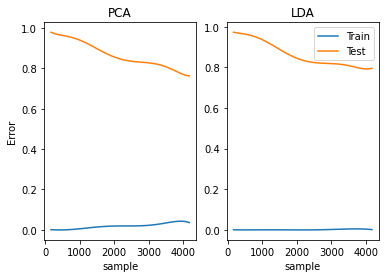

In [13]:
print('RANDOM FOREST:')
plt.xlabel("Samples")
plt.ylabel("Error")

x = np.linspace(170, 4170, 40) 
y1 = np.polyfit(x, trainErr_PCA, 6)
p1 = np.poly1d(y1)
y2 = np.polyfit(x, testErr_PCA, 6)
p2 = np.poly1d(y2)

y3 = np.polyfit(x, trainErr_LDA, 6) 
p3 = np.poly1d(y3)
y4 = np.polyfit(x, testErr_LDA, 6)
p4 = np.poly1d(y4)

plt.subplot(1, 2, 1)
plt.plot(x, p1(x), label="Train")
plt.plot(x, p2(x), label="Test")
plt.title("PCA")
plt.xlabel("sample")
plt.ylabel("Error")

plt.subplot(1, 2, 2) # index 2
plt.plot(x, p3(x), label="Train")
plt.plot(x, p4(x), label="Test")
plt.title("LDA")
plt.xlabel("sample")


plt.legend(loc="best") 
plt.show()

from the learning curves we can sea that we are at underfitted mode(more data would be awsome):

In [14]:
clf1 = RandomForestClassifier(max_depth=10, random_state=0)
clf1.fit(pca_train, Train_classes)
print("PCA:" ,clf1.score(pca_test, Test_classes))

clf2 = RandomForestClassifier(max_depth=10, random_state=0)
clf2.fit(lda_train, Train_classes)
print("ldA:" ,clf2.score(lda_test, Test_classes))

PCA: 0.23373373373373374
ldA: 0.2092092092092092


Print SVM learning curves (PCA V.S LDA):

In [15]:
from sklearn import svm

testErr_PCA = []
trainErr_PCA = []

testErr_LDA = []
trainErr_LDA = []


for i in range(170, 4170, 100):
    X_train = np.split(pca_train,[i,i])[0]
    y_train = np.split(Train_classes,[i,i])[0]
    svc1 = svm.SVC(kernel='rbf')
    svc1.fit(X_train, y_train)
    trainErr_PCA.append(1-svc1.score(X_train, y_train))
    testErr_PCA.append(1-svc1.score(pca_test, Test_classes))

for i in range(170, 4170, 100):
    X_train = np.split(lda_train,[i,i])[0]
    y_train = np.split(Train_classes,[i,i])[0]    
    svc2 = svm.SVC(kernel='rbf')
    svc2.fit(X_train, y_train)
    trainErr_LDA.append(1-svc2.score(X_train, y_train))
    testErr_LDA.append(1-svc2.score(lda_test, Test_classes))



SVM:


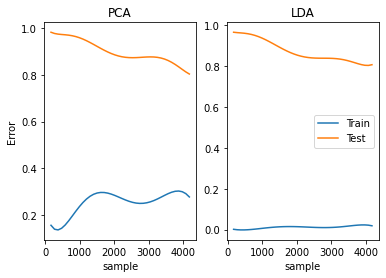

In [16]:
print('SVM:')
plt.xlabel("Samples")
plt.ylabel("Error")

x = np.linspace(170, 4170, 40) 
y1 = np.polyfit(x, trainErr_PCA, 6)
p1 = np.poly1d(y1)
y2 = np.polyfit(x, testErr_PCA, 6)
p2 = np.poly1d(y2)

y3 = np.polyfit(x, trainErr_LDA, 6) 
p3 = np.poly1d(y3)
y4 = np.polyfit(x, testErr_LDA, 6)
p4 = np.poly1d(y4)

plt.subplot(1, 2, 1)
plt.plot(x, p1(x), label="Train")
plt.plot(x, p2(x), label="Test")
plt.title("PCA")
plt.xlabel("sample")
plt.ylabel("Error")

plt.subplot(1, 2, 2)
plt.plot(x, p3(x), label="Train")
plt.plot(x, p4(x), label="Test")
plt.title("LDA")
plt.xlabel("sample")


plt.legend(loc="best") 
plt.show()

just like in RF we need more data for PCA but LDA looks like he is almost reaching his pick!

In [17]:
svc1 = svm.SVC(kernel='rbf')
svc1.fit(pca_train, Train_classes)
print("PCA:", svc1.score(pca_test, Test_classes))

svc2 = svm.SVC(kernel='rbf')
svc2.fit(lda_train, Train_classes)
print("LDA:", svc2.score(lda_test, Test_classes))

PCA: 0.19269269269269268
LDA: 0.2007007007007007


Print learning NB curves (PCA V.S LDA):

In [18]:
from sklearn.naive_bayes import GaussianNB
testErr_PCA = []
trainErr_PCA = []

testErr_LDA = []
trainErr_LDA = []


for i in range(170, 4170, 100):
    X_train = np.split(pca_train,[i,i])[0]
    y_train = np.split(Train_classes,[i,i])[0]
    gnb1 = GaussianNB()
    gnb1.fit(X_train, y_train)
    trainErr_PCA.append(1-gnb1.score(X_train, y_train))
    testErr_PCA.append(1-gnb1.score(pca_test, Test_classes))

for i in range(170, 4170, 100):
    X_train = np.split(lda_train,[i,i])[0]
    y_train = np.split(Train_classes,[i,i])[0]    
    gnb2 = GaussianNB()
    gnb2.fit(X_train, y_train)
    trainErr_LDA.append(1-gnb2.score(X_train, y_train))
    testErr_LDA.append(1-gnb2.score(lda_test, Test_classes))

GNB:


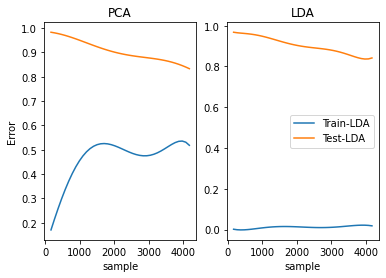

In [19]:
print('GNB:')
plt.xlabel("Samples")
plt.ylabel("Error")

x = np.linspace(170, 4170, 40) 
y1 = np.polyfit(x, trainErr_PCA, 6)
p1 = np.poly1d(y1)
y2 = np.polyfit(x, testErr_PCA, 6)
p2 = np.poly1d(y2)

y3 = np.polyfit(x, trainErr_LDA, 6) 
p3 = np.poly1d(y3)
y4 = np.polyfit(x, testErr_LDA, 6)
p4 = np.poly1d(y4)

plt.subplot(1, 2, 1)
plt.plot(x, p1(x), label="Train-PCA")
plt.plot(x, p2(x), label="Test-PCA")
plt.title("PCA")
plt.xlabel("sample")
plt.ylabel("Error")

plt.subplot(1, 2, 2)
plt.plot(x, p3(x), label="Train-LDA")
plt.plot(x, p4(x), label="Test-LDA")
plt.title("LDA")
plt.xlabel("sample")


plt.legend(loc="best") 
plt.show()

PCA would like more data!

In [20]:
gnb1 = GaussianNB()
gnb2 = GaussianNB()
gnb1.fit(pca_train, Train_classes)
gnb2.fit(lda_train, Train_classes)
print("pca:", gnb1.score(pca_test, Test_classes))
print("lda:", gnb2.score(lda_test, Test_classes))

pca: 0.16266266266266266
lda: 0.16416416416416416
